## 1.Import libraries


In [2]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


# 2.Mount google drive





In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Duong dan toi dataset
zip_path = "/content/drive/MyDrive/AI_Fruits_Dataset/dataset.zip"

# Giai nen

!unzip -q "{zip_path}" -d "/content"


# Khai bao duong dan
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

# Kiem tra su ton tai cua tep

print("Tep Train ton tai:", os.path.exists(train_dir))
print("Tep Test ton tai:", os.path.exists(test_dir))

# Kiem tra file ben trong tep
print("Tep ben trong thu muc train:", os.listdir(train_dir))

Mounted at /content/drive
Tep Train ton tai: True
Tep Test ton tai: True
Tep ben trong thu muc train: ['freshbanana', 'freshapples', 'freshoranges', 'rottenoranges', 'rottenapples', 'rottenbanana']


# 3.Image preprocessing


In [42]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Kích thước đầu vào cho mô hình MobileNetV2
img_size = (244, 244)
batch_size = 32

# Tạo ImageDataGenerator với các phép biến đổi tăng cường dữ liệu
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Chuẩn hóa giá trị ảnh về phạm vi [0, 1]
    rotation_range=15,                 # Xoay ảnh ngẫu nhiên trong phạm vi 15 độ
    zoom_range=0.1,                    # Phóng to ảnh ngẫu nhiên trong phạm vi 10%
    width_shift_range=0.1,             # Dịch chuyển ảnh theo chiều ngang trong phạm vi 10%
    height_shift_range=0.1,            # Dịch chuyển ảnh theo chiều dọc trong phạm vi 10%
    shear_range=0.1,                   # Cắt ảnh theo một góc ngẫu nhiên
    horizontal_flip=True,              # Lật ảnh theo chiều ngang
    fill_mode='nearest'                # Phương pháp điền các giá trị bị thiếu khi biến đổi ảnh
)

test_datagen = ImageDataGenerator(
    rescale=1./255                      # Chỉ chuẩn hóa giá trị ảnh cho tập kiểm tra
)


# 3.1  Reading data from Train and
 Validation





In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical' # 6 lop
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)


Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


# 4.Building model


In [18]:
from pickle import TRUE
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import layers, models

# Tải mô hình MobileNetV2 đã được huấn luyện trên ImageNet, loại bỏ lớp phân loại cuối cùng (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Đóng băng các lớp của MobileNetV2 (để không huấn luyện lại chúng)
base_model.trainable = True

# Chỉ mở khóa các lớp sau cùng của MobileNetV2 để giảm chi phí tính toán
fine_tune_at = 100  # Chỉ mở khóa lớp từ layer 100 trở đi
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Xây dựng mô hình mới
model = tf.keras.models.Sequential([
    base_model,  # Chèn MobileNetV2 như một lớp base
    GlobalAveragePooling2D(),  # Lớp Pooling toàn cục
    Dense(512, activation='relu'),  # Lớp Dense ẩn
    Dropout(0.5),  # Dropout để tránh overfitting
    Dense(6, activation='softmax')  # Lớp đầu ra với 6 lớp (tương ứng với 6 lớp phân loại)
])

# Tóm tắt mô hình
model.summary()


<ipython-input-18-e575f1546e11>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244, 244, 3))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 2,520,390 (9.61 MB)

 Non-trainable params: 396,544 (1.51 MB)

# 5. Model Training


# 5.1 Paramerter setup




In [19]:

model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [20]:


EPOCHS=80
history=model.fit(
    train_generator,
    steps_per_epoch=2,
    epochs=EPOCHS,
    verbose=1,
    validation_data = test_generator,
    validation_steps=2)

Epoch 1/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.1979 - loss: 2.2127 - val_accuracy: 0.2188 - val_loss: 1.9252
Epoch 2/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: 1.8680 - val_accuracy: 0.5156 - val_loss: 1.6119
Epoch 3/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - accuracy: 0.3229 - loss: 1.7228 - val_accuracy: 0.4219 - val_loss: 1.5598
Epoch 4/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.2917 - loss: 1.6751 - val_accuracy: 0.3906 - val_loss: 1.4801
Epoch 5/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - accuracy: 0.4688 - loss: 1.3131 - val_accuracy: 0.6562 - val_loss: 1.1798
Epoch 6/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8021 - loss: 0.8288 - val_accuracy: 0.7188 - val_loss: 1.1392
Epoch 7/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step - accuracy: 0.6354 - loss: 1.0345 - val_accuracy: 0.6250 - val_loss: 1.1765
Epoch 8/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step - accuracy: 0.6771 - loss: 0.8716 - val_accuracy: 0.6875 - val_loss: 1.1124
Epo

# 6.Chart

# 6.1 Accuracy Chart

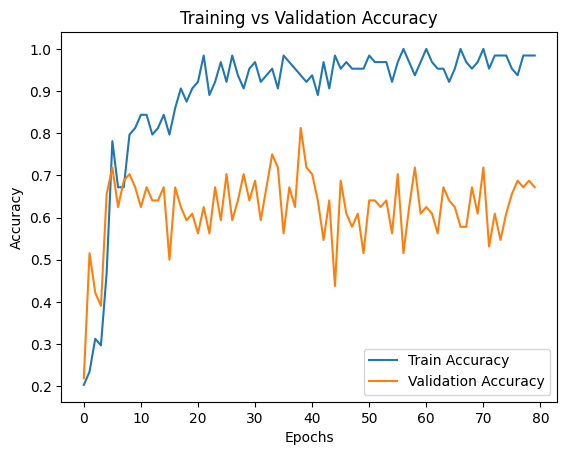

In [34]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 6.2 Loss chart

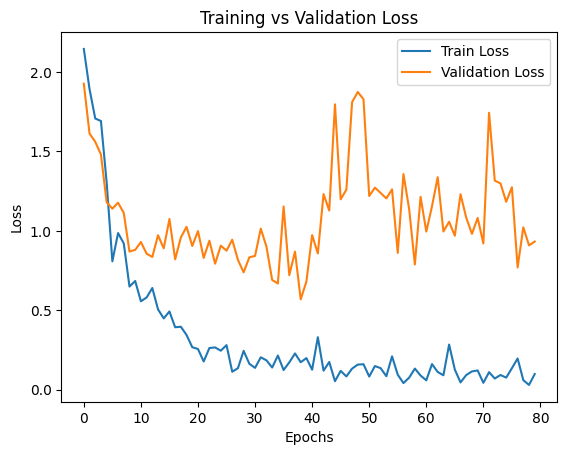

In [35]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 7. Predict a new image from local laptop

In [43]:
# Ham du doan anh moi
def predict_image(img_path):
  img = tf.keras.preprocessing.image.load_img(img_path, target_size = img_size)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = np.expand_dims(img_array/ 255.0, axis = 0)

  prediction = model.predict(img_array)
  class_idx = np.argmax(prediction)
  class_labels = list(train_generator.class_indices.keys())
  return class_labels[class_idx], prediction[0][class_idx]


# 8. Upload images from local

In [1]:

from google.colab import files
from IPython.display import display
from PIL import Image
import io



uploaded = files.upload()

for fn in uploaded.keys():
    if fn.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Mở ảnh từ file upload
        img = Image.open(fn)
        # Resize ảnh về kích thước chuẩn
        img_resized = img.resize(img_size)
        # Hiển thị ảnh đã resize
        display(img_resized)

        # Nếu predict_image nhận ảnh PIL hoặc path file, bạn có thể truyền img_resized hoặc lưu tạm file
        # Ví dụ lưu tạm rồi gọi predict
        img_resized.save('temp_resized.jpg')
        label, confidence = predict_image('temp_resized.jpg')
        print(f"\nẢnh: {fn} → Dự đoán: {label} ({confidence:.2f})")
    else:
        print(f"\n{fn}: Không phải tệp hình ảnh, bỏ qua.")


Saving saltandpepper_Screen Shot 2018-06-12 at 9.38.10 PM.png to saltandpepper_Screen Shot 2018-06-12 at 9.38.10 PM.png


NameError: name 'img_size' is not defined